Training model using kaggle Dataset

In [307]:
#importing 

import numpy as np
import pandas as pd

import matplotlib.pyplot  as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

from tensorflow import keras
from tensorflow.keras import layers


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization




#Reading data from CSV  -- May need to edit to read from sql using alchemy
data = pd.read_csv('fake_job_postings.csv')

In [308]:
#Displaying training Data
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [309]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

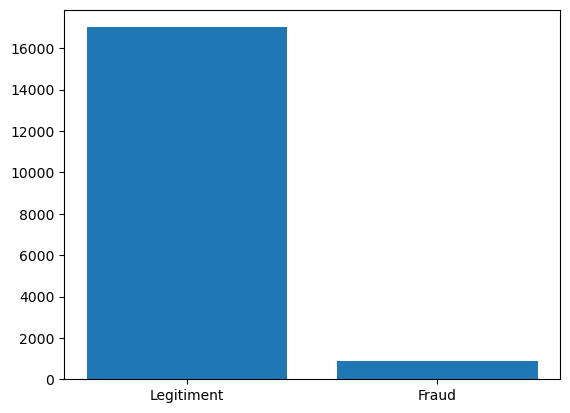

In [310]:
#Checking how much of the data is fraud vs legit

x = data['fraudulent'].value_counts()
fig, ax = plt.subplots()
titles = ['Legitiment', 'Fraud']
ax.bar(titles, x )
plt.show()

In [311]:
#Defining features and the target to be used for training the model based upon avalable data from web scraping app
features = data[['description','benefits']]
target = data['fraudulent']


In [312]:
#replacing NA with space  
features.fillna(" ",inplace=True)
features.isnull().sum()


C:\Users\aloll\AppData\Local\Temp\ipykernel_18664\3974032206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(" ",inplace=True)


description    0
benefits       0
dtype: int64

In [313]:
#Change each entry into a single string
# \xa0 is a unicode no-break space that is prevelent in a few of the entries that needed to be removed 

concat_data = []
for i in range(len(features)):
    entry = features['description'][i] + ' '
    #entry = entry + features['requirements'][i] + ' '
    entry = entry + features['benefits'][i] 
    concat_data.append(entry.strip().replace('\xa0', ''))

In [314]:
concat_data[8719]

'Job Summary:    This position is established to actively participate with the renal dialysis staff by providing basic bed side care as well as functioning as a technician skilled in all aspects of hemodialysis under the direction of the RN.    Essential Duties:     Performs treatment and patient care procedures according to unit policy and procedures.   Demonstrates and adheres to Infection Control Policies.   Documents care provided according to hospital policy.   Expresses appropriate communication to patient, families, and other customers.   Provides care according to developmental age.   Promotes safety and prevents falls.   Demonstrates flexibility to accomplish work tasks.      Qualifications    Education:     High school diploma or equivalent required.   Dialysis or other medical coursework preferred.    Experience:     One year of experience as a dialysis services technician including the preparation, operation and maintenance of kidney dialysis equipment preferred.    License

In [315]:
#finding the rough count of words in the 3rd quartile to pass to the tokenizers max length

seq_lens = [seq.count(' ') for seq in concat_data]
q3 = np.quantile(seq_lens,.75)
print(q3)

268.0


In [316]:
#creating a class to change the text into numbers first stripping punctuation and upper case

vectorize_layer = TextVectorization(max_tokens=10000, standardize='lower_and_strip_punctuation', output_sequence_length=268)

#Toeknizing the data
vectorize_layer.adapt(concat_data)

In [317]:
#Using tf to extract the tokenized data
# Model can be used to map future datasets and keep tokens consitent

tokenizer = tf.keras.models.Sequential()
tokenizer.add(tf.keras.Input(shape=(1,), dtype=tf.string))
tokenizer.add(vectorize_layer)
x_tokens = tokenizer.predict(concat_data)

559/559 [==============================] - 1s 2ms/step


In [318]:
#confirming tokenization 
x_tokens[8719]

array([  50, 2308,   27,   53,   11,  538,    3,  966,  708,    9,    4,
          1, 8672,  193,   34,  264,  615, 4424, 1716,  138,   17,   70,
         17, 3843,   17,    6, 1463, 1048,    7,   23,  476,    5,    1,
        597,    4,  512,    5,    4, 3223,  739,  173, 1703, 1277,    2,
        707,  138,  329,  879,    3, 1202,  831,    2,  329, 3096,    2,
       6671,    3,    1,  422,  502,  545,  138,  414,  879,    3, 1632,
        831,    1,  370,  140,    3,  707, 1610,    2,   43,   64,  419,
        138,  879,    3, 2416, 1149, 3147,  307,    2,    1, 4085, 3096,
        664,    3, 2429,   21,  231,  981,  561,  103,  514, 2156,   26,
       1294,  137, 8672,   26,   43,  249, 6370,  900,   33,  102,  245,
          5,   33,   17,    6, 8672,   51, 1463,   57,    4, 1110,  938,
          2,  338,    5,    1, 8672,  308,  900,    1,    1, 2027,  137,
        661,  320, 3096,    6, 1204,    3,   45,  404,  808,    2, 2891,
         85,  370, 1010,    2, 3979,   32,   23,  8

In [319]:
#building testing and training groups for the model
x_train,x_test,y_train,y_test = train_test_split(x_tokens,target,test_size=0.2,random_state=72)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14304, 268)
(3576, 268)
(14304,)
(3576,)


In [320]:
#setting input sizes for the first layer


VOCAB_SIZE = 10000 + 2
VEC_SIZE = 100
TOKEN_SIZE = int(q3)

In [321]:
#Creating the ml model
#using CuDNNGRU 

from tensorflow.compat.v1.keras.layers import CuDNNGRU
model = keras.Sequential()
model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                           output_dim=VEC_SIZE,
                           input_length=TOKEN_SIZE
                          ))



model.add(CuDNNGRU(512,return_sequences=True))
model.add(CuDNNGRU(1024,return_sequences=True))
model.add(CuDNNGRU(2048))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [322]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 268, 100)          1000200   
                                                                 
 cu_dnngru_27 (CuDNNGRU)     (None, 268, 512)          943104    
                                                                 
 cu_dnngru_28 (CuDNNGRU)     (None, 268, 1024)         4724736   
                                                                 
 cu_dnngru_29 (CuDNNGRU)     (None, 2048)              18886656  
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 25,556,745
Trainable params: 25,556,745
Non-trainable params: 0
_________________________________________________________________


In [323]:
#Training the model
hist = model.fit(x_train,y_train,validation_split=0.2,epochs=2)

Epoch 1/2
358/358 [==============================] - 28s 75ms/step - loss: 0.2065 - accuracy: 0.9498 - val_loss: nan - val_accuracy: 0.9521
Epoch 2/2
358/358 [==============================] - 26s 72ms/step - loss: nan - accuracy: 0.9504 - val_loss: nan - val_accuracy: 0.9521


In [324]:
#Testing trained model to confirm its not over or under fitteded

model_loss, model_accuracy = model.evaluate(x_test,y_test,verbose=2)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

112/112 - 3s - loss: nan - accuracy: 0.9550 - 3s/epoch - 26ms/step
Loss: nan, Accuracy: 0.9549776315689087
